In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

## Model parameters


In [2]:
sigma = 1.
S0 = 100.
T = 1.
lambda_a = 10.
lambda_b = 10.
qmax = 3
qmin = -qmax
sigma_Z = 1.
# Model for misses
alpha_a = 0.01 
alpha_b = 0.01
beta = 0.001
kappa = 100.
# Penalties
phi = 1e-4
a = 1e-3

In [3]:
all_inventories = np.arange(qmax, qmin-1, step = -1)

In [4]:
all_inventories

array([ 3,  2,  1,  0, -1, -2, -3])

In [5]:
np.argwhere(all_inventories==1)

array([[2]])

In [6]:
A_matrix = np.zeros((2*qmax+1,2*qmax+1))
z_vector = np.zeros((2*qmax+1,1))

for i in range(2*qmax+1):
    inventory = qmax - i
    A_matrix[i, i] = - phi * kappa * inventory**2
    z_vector[i, 0] = np.exp(- a * kappa * inventory**2)
    if i + 1 < (2*qmax+1):
        A_matrix[i, i + 1] = lambda_b * np.exp(-1.+kappa*alpha_b + kappa*beta/2)
    if i > 0:
        A_matrix[i, i - 1] = lambda_a * np.exp(-1.+kappa*alpha_a + kappa*beta/2)


In [7]:
def _calculate_omega_t(t):
    return np.matmul(expm(A_matrix * (T - t)) - beta*(lambda_a-lambda_b)**2*(T**2-t**2)/2*np.identity(2*qmax+1) , z_vector)

In [8]:
def _calculate_gt(t):
    omega_function = _calculate_omega_t(t)
    return 1 / kappa * np.log(omega_function)

def _calculate_ft(t):
    return beta*(lambda_a - lambda_b)*t

In [9]:
gt = _calculate_gt(0.5)

In [10]:
def _calculate_ht(t, q, d_plus_z):
    gt = _calculate_gt(t)
    
    iq = np.argwhere(all_inventories == q)[0]
    gt_at_q = gt[iq]
    
    ft = _calculate_ft(t)
    
    return gt_at_q + ft*(d_plus_z) - beta/2*(d_plus_z)**2

In [11]:
def _calculate_deltas(t, q, d_plus_z):    
    delta_tilde_a = alpha_a + beta * (d_plus_z)
    delta_tilde_b = alpha_a - beta * (d_plus_z)
    
    h_q_minus_one = _calculate_ht(t, q-1, d_plus_z)
    h_d_minus_one = _calculate_ht(t, q, d_plus_z-1)
    
    h_q_plus_one = _calculate_ht(t, q+1, d_plus_z)
    h_d_plus_one = _calculate_ht(t, q, d_plus_z+1)
    
    delta_hat_a = 1/kappa - h_q_minus_one + h_d_minus_one
    delta_hat_b = 1/kappa - h_q_plus_one + h_d_plus_one
    
    delta_a = np.maximum(delta_hat_a, delta_tilde_a)
    delta_b = np.maximum(delta_hat_b, delta_tilde_b)
    return delta_a, delta_b

In [12]:
_calculate_deltas(0.5, 0, 10)

(array([[0.02030238]]), array([[0.00030238]]))

In [13]:
t = 0.5
d_plus_z = 0

q_vector = np.arange(qmax-1,qmin,step=-1)

deltas_a = np.zeros((q_vector.shape))
deltas_b = np.zeros((q_vector.shape))

for i,q in enumerate(q_vector):
    delta_a, delta_b = _calculate_deltas(t, q, d_plus_z)
    deltas_a[i] = delta_a[0][0]
    deltas_b[i] = delta_b[0][0]

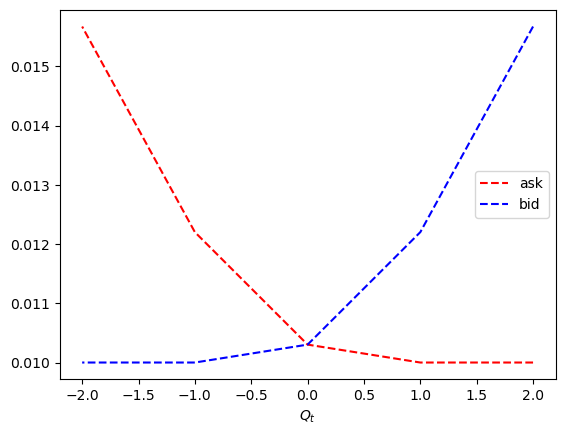

In [14]:
plt.plot(q_vector, deltas_a, 'r--')
plt.plot(q_vector, deltas_b, 'b--')
plt.xlabel(r'$Q_t$')
plt.legend(['ask','bid'])
plt.show()

In [15]:
t = 0.5
q = 0
dmax = 5
dmin = - dmax

d_plus_z_vector = np.arange(dmax-1,dmin,step=-1)

deltas_a = np.zeros((d_plus_z_vector.shape))
deltas_b = np.zeros((d_plus_z_vector.shape))

for i,d_z in enumerate(d_plus_z_vector):
    delta_a, delta_b = _calculate_deltas(t, q, d_z)
    deltas_a[i] = delta_a[0][0]
    deltas_b[i] = delta_b[0][0]

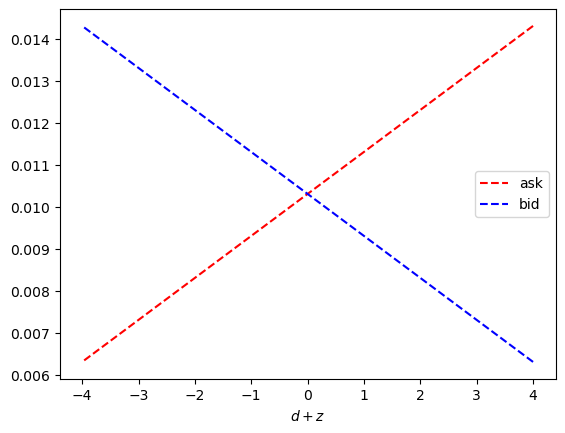

In [16]:
plt.plot(d_plus_z_vector, deltas_a, 'r--')
plt.plot(d_plus_z_vector, deltas_b, 'b--')
plt.xlabel(r'$d+z$')
plt.legend(['ask','bid'])
plt.show()

In [17]:
q_vector.shape[0]

5

In [18]:
t_vector = np.linspace(0,T,num=100)
q_vector = np.arange(qmax-1,qmin,step=-1)

d_plus_z = 0


deltas_a = np.zeros((t_vector.shape[0],q_vector.shape[0]))
deltas_b = np.zeros((t_vector.shape[0],q_vector.shape[0]))

for it,t in enumerate(t_vector):
    for iq,q in enumerate(q_vector):
        delta_a, delta_b = _calculate_deltas(t, q, d_plus_z)
        deltas_a[it,iq] = delta_a[0][0]
        deltas_b[it,iq] = delta_b[0][0]

In [23]:
 _calculate_deltas(T, 2, 0)

(array([[0.01]]), array([[0.0145]]))

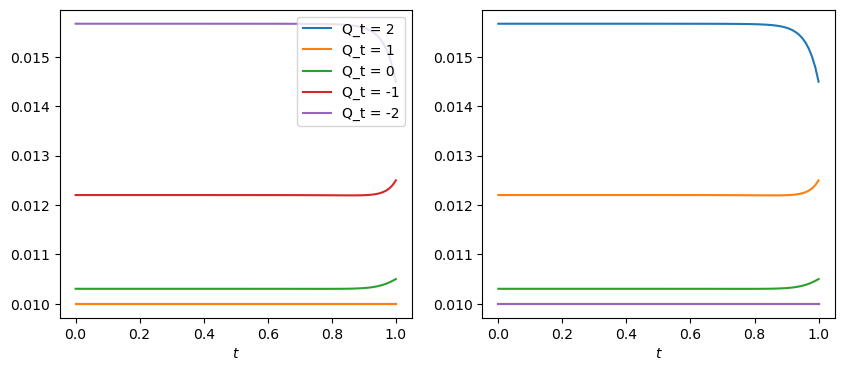

In [19]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
for iq,q in enumerate(q_vector):
    ax[0].plot(t_vector, deltas_a[:,iq])
    ax[1].plot(t_vector, deltas_b[:,iq])
ax[0].legend([f'Q_t = {q}' for q in q_vector])
ax[0].set_xlabel(r'$t$')
ax[1].set_xlabel(r'$t$')
plt.show()